In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch

In [2]:
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 256

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='crossvit_15_dagger_408',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [9]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=408, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [10]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [11]:
learn = Learner(dls,timm.create_model('crossvit_15_dagger_408',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

Downloading: "https://github.com/IBM/CrossViT/releases/download/weights-0.1/crossvit_15_dagger_384.pth" to /home/jonathan/.cache/torch/hub/checkpoints/crossvit_15_dagger_384.pth


SuggestedLRs(valley=0.0003981071640737355)

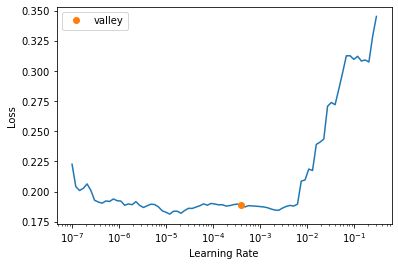

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.177464,0.173225,0.500000,0.000000,0.000000,0.000000,0.623823,04:00


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with f1_score value: 0.0.


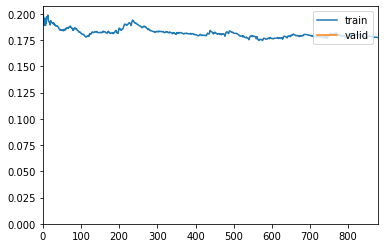

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.170555,0.167496,0.614103,0.678715,0.433333,0.528951,0.662173,04:03
1,0.166215,0.166674,0.616667,0.580247,0.843590,0.687565,0.678462,04:03
2,0.166471,0.164399,0.616667,0.579130,0.853846,0.690155,0.692488,04:01
3,0.157205,0.172310,0.592308,0.555556,0.923077,0.693642,0.699855,03:58
4,0.158720,0.168752,0.589744,0.552711,0.941026,0.696395,0.691055,03:54
5,0.159545,0.168155,0.621795,0.580645,0.876923,0.698672,0.705276,03:59
6,0.158051,0.167192,0.605128,0.563077,0.938462,0.703846,0.724211,04:00
7,0.156941,0.167317,0.633333,0.585809,0.910256,0.712851,0.715556,04:01


Better model found at epoch 0 with f1_score value: 0.5289514866979655.


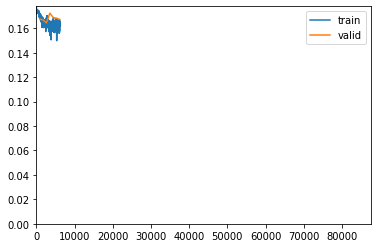

Better model found at epoch 1 with f1_score value: 0.6875653082549634.
Better model found at epoch 2 with f1_score value: 0.6901554404145077.
Better model found at epoch 3 with f1_score value: 0.6936416184971099.
Better model found at epoch 4 with f1_score value: 0.6963946869070209.
Better model found at epoch 5 with f1_score value: 0.6986721144024516.
Better model found at epoch 6 with f1_score value: 0.7038461538461538.
Better model found at epoch 7 with f1_score value: 0.7128514056224899.
No improvement since epoch 2: early stopping


In [13]:
learn.fine_tune(100,base_lr=3e-3)

In [14]:
dfTest = pd.read_csv('../testSample.csv')

In [15]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [16]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=408, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [17]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [18]:
learn.dls = dlsTest

In [19]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.6944105193951348.


(#6) [0.17249710857868195,0.6005128026008606,0.5630630630630631,0.8974358974358975,0.6919731119019376,0.6944105193951348]